### از آن جایی که پس از هر بار اجرا، دیکشنری هایی که برای کد کردن تگ ها و اینتنت ها ساخته‌ایم، با مقادیر متفاوتی مقداردهی میشوند و بهترین وزنهایی که قبلا سیو شده اند، دیگر دقت کافی را به ما نمیدهند، بهترین وزن را سیو نکرده و خواهشمند است یک دور شبکه را ترین کنین. زمان کمی میبرد. باتشکر

In [ ]:
!gdown --id 104TU-gdBAtalfRyaauuKaOobhGbB52Zf

Downloading...
From: https://drive.google.com/uc?id=104TU-gdBAtalfRyaauuKaOobhGbB52Zf
To: /content/data.zip
100% 649k/649k [00:00<00:00, 43.1MB/s]


In [ ]:
!unzip '/content/data.zip' -d '/content/data_folder/'

Archive:  /content/data.zip
replace /content/data_folder/simple-dstc2-trn.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import json

def read_json_file (PATH):
  
  f = open (PATH, "r")

  # Reading from file  
  data = json.loads(f.read())
  sentences = []
  for sent in data.keys():
    sentences.append(sent)

  nertags = []
  for datta in data.values():
    tags = datta['NERTAGS']
    nertags.append(tags)

  intents = []
  for dattaa in data.values():
    intent = dattaa['INTENTS']
    intents.append(intent)
  

  return sentences , nertags , intents

In [ ]:
sentences_train, nertags_train , intents_train = read_json_file('/content/data_folder/ner_intent_train.json')
sentences_valid, nertags_valid , intents_valid = read_json_file('/content/data_folder/ner_intent_valid.json')
sentences_test, nertags_test , intents_test= read_json_file('/content/data_folder/ner_intent_test.json')

# **Question 1**

In [ ]:
unique_tags = ['O']

total_nertags = nertags_train + nertags_valid + nertags_test

for tags in total_nertags:
  for tag in tags:
    unique_tags.append(tag)

unique_tags = set(unique_tags)

In [ ]:
n_tags = len(unique_tags)

In [ ]:
n_tags

11

In [ ]:
tags2index = {t:i for i,t in enumerate(unique_tags)}

In [ ]:
tags2index

{'B-area': 3,
 'B-food': 10,
 'B-name': 1,
 'B-pricerange': 9,
 'B-this': 6,
 'I-area': 8,
 'I-food': 4,
 'I-name': 5,
 'I-pricerange': 2,
 'I-this': 7,
 'O': 0}

In [ ]:
key_list = list(tags2index.keys())
val_list = list(tags2index.values())

In [ ]:
def get_int_tag (seq_tags):

  int_nertags = []
  for tags in seq_tags:
    int_tags = [tags2index[tag] for tag in tags]
    int_nertags.append(int_tags)
  return int_nertags


In [ ]:
int_nertags_train = get_int_tag (nertags_train)
int_nertags_valid = get_int_tag (nertags_valid)
int_nertags_test = get_int_tag (nertags_test)

In [ ]:
int_nertags_train[7] , nertags_train[7]

([10, 0], ['B-food', 'O'])

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train+sentences_test+sentences_valid)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_valid = tokenizer.texts_to_sequences(sentences_valid)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1 

### دو سلول بعدی برای این که انتخاب درستی از حداکثر طول جمله ورودی به شبکه داشته باشیم، نوشته شده است.

In [ ]:
sent_length = {}

for elem in X_train:
  res = len(elem)
  if res in sent_length:
    sent_length[res]+=1
  else:
    sent_length[res]=1

print(sent_length)

{2: 196, 1: 145, 4: 246, 5: 239, 12: 68, 10: 89, 3: 173, 7: 127, 11: 87, 9: 121, 6: 182, 8: 132, 16: 18, 13: 54, 18: 3, 15: 25, 14: 26, 17: 2}


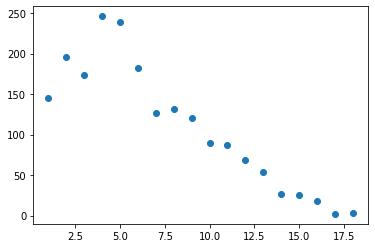

In [ ]:
import matplotlib.pyplot as plt

x = [key for key in sent_length]
y = [sent_length[key] for key in sent_length]

plt.scatter(x, y)
plt.show()

In [ ]:
max_len = 8

In [ ]:
# pad sentences and their tag_seqs
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_valid = pad_sequences(X_valid, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)


nertags_train = pad_sequences(int_nertags_train,  padding='post', maxlen=max_len, value=tags2index["O"])
nertags_valid = pad_sequences(int_nertags_valid,  padding='post', maxlen=max_len, value=tags2index["O"])
nertags_test = pad_sequences(int_nertags_test,  padding='post', maxlen=max_len, value=tags2index["O"])

In [ ]:
X_train[3], nertags_train[3]

(array([18,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [ ]:
# Reshape taq_sequences in order to give to the network.
nertags_train = nertags_train.reshape(nertags_train.shape[0], nertags_train.shape[1], 1)
nertags_valid = nertags_valid.reshape(nertags_valid.shape[0], nertags_valid.shape[1], 1)
nertags_test = nertags_test.reshape(nertags_test.shape[0], nertags_test.shape[1], 1)

In [ ]:
# Define slot_filling_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, GRU

embedding_dim = 100

slot_filling_model = Sequential()
slot_filling_model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len,
                           trainable=True))

slot_filling_model.add(Bidirectional(GRU(300, dropout=0.2,  return_sequences=True)))
slot_filling_model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

In [ ]:
slot_filling_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8, 100)            63500     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 8, 600)            723600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 11)             6611      
Total params: 793,711
Trainable params: 793,711
Non-trainable params: 0
_________________________________________________________________


In [ ]:
slot_filling_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# define checkpoint
checkpoint_1 = ModelCheckpoint('/content/slot_filling_model-{epoch:03d}--{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, 
                             save_weights_only=True, mode='max') 


batch_size = 32
import numpy as np

history1 = slot_filling_model.fit(np.array(X_train), nertags_train, validation_data=(np.array(X_valid), nertags_valid),
                    batch_size=batch_size, epochs=8, verbose=1 ,callbacks=[checkpoint_1])

Epoch 1/8
61/61 [==============================] - 5s 30ms/step - loss: 0.7442 - accuracy: 0.8696 - val_loss: 0.3746 - val_accuracy: 0.8861

Epoch 00001: val_accuracy improved from -inf to 0.88608, saving model to /content/slot_filling_model-001--0.886080.h5
Epoch 2/8
61/61 [==============================] - 1s 18ms/step - loss: 0.2295 - accuracy: 0.9321 - val_loss: 0.1181 - val_accuracy: 0.9765

Epoch 00002: val_accuracy improved from 0.88608 to 0.97654, saving model to /content/slot_filling_model-002--0.976541.h5
Epoch 3/8
61/61 [==============================] - 1s 18ms/step - loss: 0.0868 - accuracy: 0.9818 - val_loss: 0.0722 - val_accuracy: 0.9832

Epoch 00003: val_accuracy improved from 0.97654 to 0.98321, saving model to /content/slot_filling_model-003--0.983206.h5
Epoch 4/8
61/61 [==============================] - 1s 18ms/step - loss: 0.0582 - accuracy: 0.9855 - val_loss: 0.0580 - val_accuracy: 0.9852

Epoch 00004: val_accuracy improved from 0.98321 to 0.98520, saving model to 

In [ ]:
pred = slot_filling_model.predict(np.array(X_test))
pred = pred.reshape(pred.shape[0]*pred.shape[1], pred.shape[2])
predicted_tag = [np.argmax(elem) for elem in pred]

In [ ]:
test_tag = nertags_test.reshape(nertags_test.shape[0]*nertags_test.shape[1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predicted_tag, test_tag))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9888
           1       0.00      0.00      0.00         0
           2       0.82      0.95      0.88        19
           3       0.99      0.98      0.99       315
           4       0.69      0.80      0.74        25
           5       0.00      0.00      0.00         0
           6       0.74      0.81      0.77        21
           7       0.56      0.82      0.67        17
           8       0.76      1.00      0.87        13
           9       0.99      1.00      0.99       230
          10       0.96      0.98      0.97       560

    accuracy                           0.99     11088
   macro avg       0.68      0.76      0.72     11088
weighted avg       0.99      0.99      0.99     11088



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Question1-1**

In [ ]:
#Downlod data
!gdown --id 1-ay5mBPEFuzHGZpDnBJIA5e_ONAIcvjW

Downloading...
From: https://drive.google.com/uc?id=1-ay5mBPEFuzHGZpDnBJIA5e_ONAIcvjW
To: /content/slot-test.txt
100% 223/223 [00:00<00:00, 240kB/s]


In [ ]:
#Read data and tokenize and pad it
sample_data = []
with open('/content/slot-test.txt', 'r') as ptr:
  for line in ptr:
    sample_data.append(line)


X_sample = tokenizer.texts_to_sequences(sample_data)
X_sample = pad_sequences(X_sample, padding='post', maxlen=max_len)

In [ ]:
pred1 = slot_filling_model.predict(np.array(X_sample))
pred1 = pred1.reshape(pred1.shape[0]*pred1.shape[1], pred1.shape[2])

In [ ]:
np.shape(pred1)

(40, 11)

In [ ]:
predicted_tag1 = [np.argmax(elem) for elem in pred1]

In [ ]:
np.shape(predicted_tag1)

(40,)

### در این قسمت جملات موجود در دیتاست داده شده به همراه تگ‌هایی که به هر کلمه نسبت داده شده چاپ می‌گردد. توجه شود که جملات به طول 8 پد شده اند. بنابراین برای جملات با بیشتر از 8 کلمه، کلمات اضافی از اول جمله برداشته شده اند. در هنگام مطابقت دادن تگ‌ها با کلمات متناظر، به این موضوع توجه شود.

In [ ]:
for i in range(0,len(sample_data)):
  labels=[]
  for tag in predicted_tag1[8*i : 8*(i+1)]:
    position = val_list.index(tag)
    label = key_list[position]
    labels.append(label)
  print('SENTENCE:',sample_data[i],'\n','NERTAGS:',labels)
  print('\n')

SENTENCE: cheap restaurant
 
 NERTAGS: ['B-pricerange', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


SENTENCE: im looking for a cheap restaurant in the south part of town
 
 NERTAGS: ['B-pricerange', 'O', 'O', 'O', 'B-area', 'O', 'O', 'O']


SENTENCE: i want a restaurant in the north part of town
 
 NERTAGS: ['O', 'O', 'O', 'O', 'B-area', 'O', 'O', 'O']


SENTENCE: what is the address and phone number
 
 NERTAGS: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


SENTENCE: i got to find a cheap restaurant that serves mexican food
 
 NERTAGS: ['O', 'O', 'B-pricerange', 'O', 'O', 'O', 'B-food', 'O']




# **Question2**

## در این مرحله ابتدا دنباله‌ی اینتنت ها را به ساختار مناسبی در اورده تا بتوان از آن ها به عنوان تارگت شبکه استفاده نمود.

In [ ]:
total_intents = intents_train + intents_valid + intents_test
unique_intents = []
for intents in total_intents:
  for intent in intents:
    unique_intents.append(intent)

unique_intents = set(unique_intents)

In [ ]:
n_ints = len(unique_intents)

In [ ]:
unique_intents

{'ack',
 'affirm',
 'bye',
 'confirm_area',
 'confirm_food',
 'confirm_pricerange',
 'deny_food',
 'deny_name',
 'hello',
 'inform_area',
 'inform_food',
 'inform_name',
 'inform_pricerange',
 'inform_this',
 'negate',
 'repeat',
 'reqalts',
 'reqmore',
 'request_addr',
 'request_area',
 'request_food',
 'request_name',
 'request_phone',
 'request_postcode',
 'request_pricerange',
 'request_signature',
 'restart',
 'thankyou',
 'unknown'}

In [ ]:
n_ints

29

In [ ]:
intents2index = {t:i for i,t in enumerate(unique_intents)}

In [ ]:
intents2index

{'ack': 8,
 'affirm': 16,
 'bye': 18,
 'confirm_area': 5,
 'confirm_food': 3,
 'confirm_pricerange': 10,
 'deny_food': 0,
 'deny_name': 27,
 'hello': 9,
 'inform_area': 12,
 'inform_food': 1,
 'inform_name': 23,
 'inform_pricerange': 21,
 'inform_this': 6,
 'negate': 7,
 'repeat': 17,
 'reqalts': 11,
 'reqmore': 26,
 'request_addr': 20,
 'request_area': 14,
 'request_food': 13,
 'request_name': 28,
 'request_phone': 24,
 'request_postcode': 25,
 'request_pricerange': 22,
 'request_signature': 4,
 'restart': 15,
 'thankyou': 2,
 'unknown': 19}

In [ ]:
intent_key_list = list(intents2index.keys())
intent_val_list = list(intents2index.values())

In [ ]:
import numpy as np

def get_labels (seq_ints):
  y = np.zeros((len(seq_ints),len(intents2index)))

  for i,intents in enumerate(seq_ints):
    for intent in intents:
      y[i][intents2index[intent]]=1
  return y


In [ ]:
train_labels = get_labels(intents_train)
valid_labels = get_labels(intents_valid)
test_labels = get_labels(intents_test)

In [ ]:
intents_train[5] , train_labels[5]

(['thankyou', 'bye'],
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
#Define model

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, GRU

embedding_dim = 100

intent_detect_model = Sequential()
intent_detect_model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len,
                           trainable=True))

intent_detect_model.add(Bidirectional(GRU(300, dropout=0.2,  return_sequences=False)))
intent_detect_model.add(Dense(29, activation="sigmoid"))

In [ ]:

intent_detect_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# define checkpoint
checkpoint_2 = ModelCheckpoint('/content/intent_detect_model-{epoch:03d}--{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, 
                             save_weights_only=True, mode='max') 

batch_size = 32
import numpy as np

history2 = intent_detect_model.fit(np.array(X_train), train_labels, validation_data=(np.array(X_valid), valid_labels),
                    batch_size=batch_size, epochs=30, verbose=1, callbacks=[checkpoint_2])

Epoch 1/30
61/61 [==============================] - 6s 31ms/step - loss: 0.2400 - accuracy: 0.3238 - val_loss: 0.1385 - val_accuracy: 0.4010

Epoch 00001: val_accuracy improved from -inf to 0.40097, saving model to /content/intent_detect_model-001--0.400970.h5
Epoch 2/30
61/61 [==============================] - 1s 18ms/step - loss: 0.1286 - accuracy: 0.4066 - val_loss: 0.1132 - val_accuracy: 0.4536

Epoch 00002: val_accuracy improved from 0.40097 to 0.45360, saving model to /content/intent_detect_model-002--0.453601.h5
Epoch 3/30
61/61 [==============================] - 1s 17ms/step - loss: 0.0975 - accuracy: 0.4925 - val_loss: 0.0871 - val_accuracy: 0.5166

Epoch 00003: val_accuracy improved from 0.45360 to 0.51662, saving model to /content/intent_detect_model-003--0.516621.h5
Epoch 4/30
61/61 [==============================] - 1s 18ms/step - loss: 0.0750 - accuracy: 0.5758 - val_loss: 0.0679 - val_accuracy: 0.5554

Epoch 00004: val_accuracy improved from 0.51662 to 0.55540, saving mo

In [ ]:
pred2 = intent_detect_model.predict(np.array(X_test))

## در این سلول احتمالات هر کدام از درایه‌های داخل پردیکشن را چک کرده و در صورتی که بالاتر از مقدار آستانه باشد، به آن اندیس یک و در غیر اینصورت به آن اندیس صفر داده میشود. به اینصورت میتوان دقت و دیگر معیارها را محاسبه نمود.

In [ ]:
predicted_labels=np.zeros(pred2.shape)
threshold = 0.05
for i,preds in enumerate(pred2):
  for j,pred in enumerate(preds):
    if pred>= threshold:
      predicted_labels[i][j]=1


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predicted_labels, test_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.96      0.93      0.94       552
           2       1.00      0.47      0.64        59
           3       1.00      0.47      0.64        40
           4       0.00      0.00      0.00         0
           5       1.00      0.33      0.50         6
           6       0.70      0.68      0.69        31
           7       0.75      0.78      0.77        23
           8       0.25      0.14      0.18         7
           9       0.53      0.73      0.62        11
          10       1.00      0.83      0.91         6
          11       0.90      0.72      0.80       145
          12       0.97      0.98      0.98       312
          13       0.93      0.88      0.90        43
          14       0.92      0.71      0.80        34
          15       0.00      0.00      0.00         1
          16       0.65      0.71      0.68        34
          17       0.62    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Q2-1**

In [ ]:
#download data
!gdown --id 101uOTEhpm7t3Y4iIPpA_isGUHGKXafsA

Downloading...
From: https://drive.google.com/uc?id=101uOTEhpm7t3Y4iIPpA_isGUHGKXafsA
To: /content/intent-test.txt
100% 249/249 [00:00<00:00, 442kB/s]


In [ ]:
#read data and tokenize and pad it
sample_data2 = []
with open('/content/intent-test.txt', 'r') as ptr:
  for line in ptr:
    sample_data2.append(line)

X_sample2 = tokenizer.texts_to_sequences(sample_data)
X_sample2 = pad_sequences(X_sample2, padding='post', maxlen=max_len)

In [ ]:
pred3 = intent_detect_model.predict(np.array(X_sample2))

In [ ]:
sample_predicted_labels=np.zeros(pred3.shape)
for i,preds in enumerate(pred3):
  for j,pred in enumerate(preds):
    if pred>= threshold:
      sample_predicted_labels[i][j]=1


In [ ]:
for i in range(0,len(X_sample2)):
  prdiction = sample_predicted_labels[i]
  
  intnts=[]
  for j,intnt in enumerate(prdiction):
    
    if intnt==1:

      position2 = intent_val_list.index(j)
      intent = intent_key_list[position2]
      intnts.append(intent)

  print(sample_data2[i],'\n','Predicted_intent:',intnts)
  print('\n')


is it in the cheap price range
 
 Predicted_intent: ['inform_pricerange']


is there a cheap restaurant that serves vietnamese food
 
 Predicted_intent: ['inform_area', 'inform_pricerange']


can i please have their phone number
 
 Predicted_intent: ['inform_area']


no thank you good bye
 
 Predicted_intent: ['request_addr', 'request_phone']


i am looking for an expensive restaurant that serves australian food
 
 Predicted_intent: ['inform_food', 'inform_pricerange']




# **Question3-ب**

In [ ]:
# get resturanets information from simple-dstc2 files
import json

resturaenets = []
rest_names=[]
f1 = open ('/content/data_folder/simple-dstc2-trn.json', "r")
data1 = json.loads(f1.read())

for dialogues in data1:
  for dialogue in dialogues:
    if "db_result" in dialogue.keys():
      if "name" in dialogue['db_result'].keys():

        resturaenets.append(dialogue['db_result'])
        rest_names.append(dialogue['db_result']["name"])

f2 = open ('/content/data_folder/simple-dstc2-val.json', "r")
data2 = json.loads(f2.read())

for dialogues in data2:
  for dialogue in dialogues:
    if "db_result" in dialogue.keys():
      if "name" in dialogue['db_result'].keys():

        resturaenets.append(dialogue['db_result'])
        rest_names.append(dialogue['db_result']["name"])

f3 = open ('/content/data_folder/simple-dstc2-tst.json', "r")
data3 = json.loads(f3.read())

for dialogues in data3:
  for dialogue in dialogues:
    if "db_result" in dialogue.keys():
      if "name" in dialogue['db_result'].keys():
       
        resturaenets.append(dialogue['db_result'])
        rest_names.append(dialogue['db_result']["name"])

## در سلول زیر ابتدا چک میشود که کدام رستوران ها همه ی اطلاعاتشان موجود نیست. سپس بررسی میشود در صورت وجود رستوران دیگری با همان نام، اطلاعاتشان با هم به اشتراک گذاشته شود تا در صورت امکان فیلدهای خالی پر شوند. و در نهایت اگر باز هم فیلد خالی در اطلاعات هر رستوران وجود داشته باشد، با گزینه‌ی "مهم نیست" پر شود.

In [ ]:


rests = []
for rest1 in resturaenets:
  if not (len(rest1.keys())==7):
    name = rest1['name']

    for rest2 in resturaenets:
      if rest2['name']==name:

        rest1.update(rest2)
    
    if not ('food' in rest1.keys()):
      rest1['food'] = 'dontcare'

    if not ('area' in rest1.keys()):
      rest1['area'] = 'dontcare'

    if not ('pricerange' in rest1.keys()):
      rest1['pricerange'] = 'dontcare'

    if not ('phone' in rest1.keys()):
      rest1['phone'] = 'dontcare'

    if not ('addr' in rest1.keys()):
      rest1['addr'] = 'dontcare'

    if not ('postcode' in rest1.keys()):
      rest1['postcode'] = 'dontcare'


In [ ]:
# get uniqe resturanets
uniqe_resturanets = []
rest_names = []

for rest in resturaenets:
  if not (rest['name'] in rest_names):
    uniqe_resturanets.append(rest)
    rest_names.append(rest['name'])

In [ ]:
# sort resturanets in alphabetical order

from operator import itemgetter
newlist = sorted(uniqe_resturanets, key=itemgetter('name')) 


In [ ]:
#sort each dictionary of resturanets in specific order (as mentioned in the question)

import collections

resturanets = []
first_char ={}
for i,elem in enumerate(newlist):
  resturanet = collections.OrderedDict()
  resturanet['name']=elem['name']
  first_char[elem['name']]=i

  resturanet['food']=elem['food']
  resturanet['area']=elem['area']
  resturanet['pricerange']=elem['pricerange']
  resturanet['phone']=elem['phone']
  resturanet['addr']=elem['addr']
  resturanet['postcode']=elem['postcode']
  resturanets.append(resturanet)

In [ ]:
len(resturanets)

109

In [ ]:
resturanets

[OrderedDict([('name', 'ali baba'),
              ('food', 'lebanese'),
              ('area', 'centre'),
              ('pricerange', 'moderate'),
              ('phone', '01462 432565'),
              ('addr', '59 hills road city centre'),
              ('postcode', 'c.b 2, 1 n.t')]),
 OrderedDict([('name', 'anatolia'),
              ('food', 'turkish'),
              ('area', 'centre'),
              ('pricerange', 'moderate'),
              ('phone', '01223 362372'),
              ('addr', '30 bridge street city centre'),
              ('postcode', 'c.b 2, 1 u.j')]),
 OrderedDict([('name', 'ask'),
              ('food', 'italian'),
              ('area', 'centre'),
              ('pricerange', 'cheap'),
              ('phone', '01223 364917'),
              ('addr', '12 bridge street city centre'),
              ('postcode', 'c.b 2, 1 u.f')]),
 OrderedDict([('name', 'backstreet bistro'),
              ('food', 'gastropub'),
              ('area', 'dontcare'),
              ('pricer

In [ ]:
# Creat json file of resturanets informations
with open("rests_dict.json", "w") as outfile:
    json.dump(resturanets, outfile)

In [ ]:
#Download resturanets informations
!gdown --id 1RsFN-ZSXkO4eK8205vFx_HPDfd4Ke8uE

Downloading...
From: https://drive.google.com/uc?id=1RsFN-ZSXkO4eK8205vFx_HPDfd4Ke8uE
To: /content/rests_dict.json
100% 20.0k/20.0k [00:00<00:00, 33.4MB/s]


In [ ]:
# Read resturanets informations 
import json
f = open ('/content/rests_dict.json', "r")
resturanets = json.loads(f.read())

# **Question 3-1**

In [ ]:
# download data
!gdown --id 1gGUeQKCDuM_7WI4JbhDzCR3Wo6Pi2nLS


Downloading...
From: https://drive.google.com/uc?id=1gGUeQKCDuM_7WI4JbhDzCR3Wo6Pi2nLS
To: /content/db-test.txt
100% 111/111 [00:00<00:00, 176kB/s]


In [ ]:
sample_data = []
with open('/content/db-test.txt', 'r') as ptr:
  queries=[]
  lines=[]
  for line in ptr:
    line = line.replace('.', '')
    line = line.replace(',', '')
    line = line.replace('?', '')
    line = line.replace('!', '')
    line = line.strip()
    lines.append(line)
    queriess=line.split('   ')
    d=[]
    for query in queriess:
      query=query.strip()
      c=[]
      a = query.split(':')
      for b in a:
        b=b.strip()
        c.append(b)
      d.append(c)
    queries.append(d)
queries

[[['food', 'indian'], ['phone', '01223 506055']],
 [['pricerange', 'cheap'], ['area', 'east']],
 [['phone', '01223 311911'], ['area', 'centre']]]

In [ ]:
set_target_rests=[]
for query_set in queries:
  target_rests=[]
  for rest in resturanets:
    if rest[query_set[0][0]] == query_set[0][1]:
      if rest[query_set[1][0]]== query_set[1][1]:
        target_rests.append(rest['name'])
  set_target_rests.append(target_rests)

In [ ]:
for i,line in enumerate(lines):
  print(line,'\n',len(set_target_rests[i]),'\n',set_target_rests[i],'\n\n\n\n')

food: indian    phone: 01223 506055 
 1 
 ['tandoori palace'] 




pricerange: cheap   area: east 
 1 
 ['the missing sock'] 




phone: 01223 311911    area: centre 
 1 
 ['kymmoy'] 






# **Question4**

In [ ]:
# given the ID of word returns its corresponding word
def convert_ID_to_word(ID):   
  for word, index in tokenizer.word_index.items():
    if index == ID:
      return word



def get_slots (sent):
  samplex=[sent]
  tokenized_sample = tokenizer.texts_to_sequences(samplex)
  pad_sample = pad_sequences(tokenized_sample, padding='post', maxlen=max_len)
  pred_slot = slot_filling_model.predict(np.array(pad_sample))
  pred_slot = pred_slot.reshape(pred_slot.shape[0]*pred_slot.shape[1], pred_slot.shape[2])
  predicted_tagsx = [np.argmax(elem) for elem in pred_slot]
  
  slots={}
  for i , tag in enumerate(predicted_tagsx):
    position = val_list.index(tag)
    label = key_list[position]

    if not (label=='O'):

      if label=='B-food' or label== 'I-food':
        if label=='B-food':
          slots['food'] = convert_ID_to_word(pad_sample[0][i])
        else:
          slots['food'] = ' '.join([slots['food'] , convert_ID_to_word(pad_sample[0][i])])
      
      if label=='B-area' or label== 'I-area':
        if label=='B-area':
          slots['area'] = convert_ID_to_word(pad_sample[0][i])
        else:
          slots['area'] = ' '.join([slots['area'] , convert_ID_to_word(pad_sample[0][i])])


      if label=='B-pricerange' or label== 'I-pricerange':
        if label=='B-pricerange':
          slots['pricerange'] = convert_ID_to_word(pad_sample[0][i])
        else:
          slots['pricerange'] = ' '.join([slots['pricerange'] , convert_ID_to_word(pad_sample[0][i])])

  return slots


In [ ]:
def get_intents (sent):

  samplex=[sent]
  tokenized_sample = tokenizer.texts_to_sequences(samplex)
  pad_sample = pad_sequences(tokenized_sample, padding='post', maxlen=max_len)
  pred_intent = intent_detect_model.predict(np.array(pad_sample))


  sample_predicted_labels=np.zeros((29))
  for i,preds in enumerate(pred_intent):
    for j , pred in enumerate(preds):

      if pred>= threshold:
        sample_predicted_labels[j]=1

  prdiction = sample_predicted_labels
  intnts=[]
  for j,intnt in enumerate(prdiction):
    if intnt==1:
      position2 = intent_val_list.index(j)
      intent = intent_key_list[position2]
      intnts.append(intent)

  return intnts


In [ ]:
another_inf ={'food':['Yes and where do you want this restaurant to be located?','What price range do you want to spend?','Sure. in which area?'],
              'area':['What kind of food do you like?','Could you let me know  what price range do you want to spend?','And what kind of food?'],
              'pricerange':['Great. What area are you looking for?','What food do you want to eat?','ok. in which area?']}

help=['Hi, wellcome! I am Sarabot. how can I help you','Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?']

no_resturanet =['Unfortunately, there is no restaurant with these specifications','Sorry. There is no restaurant to offer you.','bad news. There is no restaurant with this information. Please change some items if possible.']

one_recomed = {'area_food':['Ok. I just found one resturanet. It is #name .','Only one restaurant with this information was found." #name " Restaurant. I heard it has good #food food.','You know I like #food food too. There is only " #name " restaurant in #area you can go to.','You can go to " #name " Restaurant. There is only this resturanet that serves #food in #area .', '#name serves #food food.'],
               'area_pricerange':['Ok. I just found one resturanet. It is #name .','There is only one restaurants with these specifications. It is " #name ".','The only resturanet to offer is " #name ".' , 'OK. Due to information you gave me, I found just one good restaurants for you." #name ".' , 'In this pricerange #name is best choice for #food food.'],
               'pricerange_food':['#name has good #food food in this town.','Only one restaurant with this information was found." #name "  Restaurant.','Ok. I just found one resturanet. It is #name .','#name serves #food food in this pricerange','#name has great #pricerange #food food.']}

area_food = ['Ok. I have a recommend to you. It is #name .','#name serves #food food in #area of town.','Due to this information, I think you should go " #name " Restaurant. I heard it has good #food food in #area .','You know I like #food food too. You can go to " #name " restaurant in #area ','#food food in #area right? Ok I found #name to you.', '#name serves #food food in #area .']

area_pricerange = ['I found some restaurants for you. I suggest " #name " restaurant.','Ok. I have a recommend to you. It is #name .','#name has #pricerange food in #area of town.','Due to this information, I think you should go " #name " Restaurant. I heard it is one of best in #area .','You can go to " #name " restaurant in #area . It has #pricerange food.']                   
                        
pricerange_food = ['I found some restaurants for you. I suggest " #name " restaurant.','#name has #pricerange #food food.','With this pricerange," #name " has good #food food.','#pricerange and #food food right? So you should go #name .']            


phone_sample =['Sure, #phone .','The phone number of #name resturanet is #phone .','Its here #phone .']
addr_sample =['Sure, #addr ','The #name resturanet is on #addr .' , 'The address of #name resturanet is #addr .']
postcode_sample =['Sure, #postcode ','The postcode of #name is #postcode .','I know it. it is #postcode .']


In [ ]:
import random

def speaker_1 (sent, turn, ex_slots, target_rest,ii ):
  
  slots = get_slots(sent)
  intents = get_intents (sent)

  if 'reqalts' in intents:
    ii+=1
    slots.update(ex_slots)

  if 'request_addr' in intents:
    if not (target_rest==''):
      for rest in resturanets:
        if rest['name']== target_rest:

          sentence =''
          for token in (random.sample(addr_sample, 1))[0].split():
            if token=='#addr':
              sentence= ' '.join([sentence, rest['addr']])
            elif token=='#name':
              sentence=' '.join([sentence,target_rest])
            else:
              sentence= ' '.join([sentence, token])

          response = sentence
    else:
      response='You dont choice any resturanet yet.'



  elif 'request_phone' in intents:
    if not (target_rest==''):
      for rest in resturanets:
        if rest['name']== target_rest:

          sentence =''
          for token in (random.sample(phone_sample, 1))[0].split():
            if token=='#phone':
              sentence= ' '.join([sentence, rest['phone']])
            elif token=='#name':
              sentence=' '.join([sentence,target_rest])
            else:
              sentence = ' '.join([sentence, token])

          response = sentence
    else:
      response='You dont choice any resturanet yet.'


  elif 'request_postcode' in intents:
    if not (target_rest==''):
      for rest in resturanets:
        if rest['name']== target_rest:
          
          sentence =''
          for token in (random.sample(postcode_sample, 1))[0].split():
            if token=='#postcode':
              sentence= ' '.join([sentence, rest['postcode']])
            elif token=='#name':
              sentence=' '.join([sentence,target_rest])
            else:
              sentence= ' '.join([sentence, token])

          response = sentence
    else:
      response='You dont choice any resturanet yet.'

  elif 'thankyou' in intents:
    response = 'Your welcome'

  elif 'bye' in intents:
    response = 'Your welcome'

  elif len(slots)== 0:
    response = random.sample(help, 1)[0]


  elif len(slots)==1 and turn==0:
    
    if 'food' in slots.keys():
      
      response = random.sample( list (another_inf['food']), 1)[0]

    if 'area' in slots.keys():
      response = random.sample( list (another_inf['area']), 1)[0]

    if 'pricerange' in slots.keys():
      response = random.sample( list (another_inf['pricerange']), 1)[0]

  elif len(slots)==1 and turn==1:

    slots.update(ex_slots)
    response ,target_rest = two_slof_fill (slots,target_rest,ii)


  elif len(slots)>1:

    response , target_rest = two_slof_fill (slots,ii)
    
  return response , slots , target_rest,ii


def two_slof_fill (slots ,ii):

  key_list_s = list(slots.keys())
  val_list_s = list(slots.values())
  target_rests=[]

  for rest in resturanets:
    if rest[key_list_s[0]] == val_list_s[0]:
      if rest[key_list_s[1]]== val_list_s[1]:
        target_rests.append(rest['name'])


  if len(target_rests)==0 :
    response = random.sample(no_resturanet, 1)[0]

  if len(target_rests)==1:

    if ('food' and 'area') in slots:
      sample_sents = one_recomed['area_food']

    if 'area' and ('pricerange') in slots:
      sample_sents = one_recomed['area_pricerange']

    if ('pricerange' and 'food') in slots:
      sample_sents = one_recomed['pricerange_food']


    sentence=''
    target_rest = target_rests[0]
    for token in (random.sample(one_recomed, 1))[0].split():

      if token=='#name':
        sentence= ' '.join([sentence,target_rest])

      elif token=='#area':
        sentence= ' '.join([sentence, slots['area']])

      elif token=='#food':
        sentence= ' '.join([sentence,slots['food']])

      elif token=='#pricerange':
        sentence= ' '.join([sentence,slots['pricerange']])

      else:
        sentence= ' '.join([sentence,token])

    response = sentence

  if len(target_rests)>1:

    if 'area' in slots:
      if 'food' in slots:
        sample_sents = area_food

    if 'area' in slots:
      if 'pricerange' in slots:
        sample_sents = area_pricerange

    if 'pricerange' in slots:
      if 'food' in slots:
        sample_sents = pricerange_food

    sentence=''
    if len(target_rests)<= ii:

      response = random.sample(['There is no more resturanet. That is it.','unfortunately , There is no other restaurant.'],1)[0]
      target_rest = target_rests[len(target_rests) -1]

    else:

      target_rest = target_rests[ii]
      for token in (random.sample(sample_sents, 1))[0].split():

        if token=='#name':
            
          sentence= ' '.join([sentence,target_rest])


        elif token=='#area':
          sentence= ' '.join([sentence,slots['area']])

        elif token=='#food':
          sentence= ' '.join([sentence,slots['food']])

        elif token=='#pricerange':
          sentence= ' '.join([sentence,token])
          
        else:
          sentence= ' '.join([sentence,token])

      response = sentence

  return response , target_rest


## **برای شروع مکالمه، سلول زیر را تنها در شروع مکالمه اجرا کنید. **

In [ ]:
#...................start.....................
#...................RESET.....................
# every time you want start "new conversation" , please run theis cell first
turn = 0
target_rest=''
ex_slots = {}
ii=0

## *برای مکالمه تنها کافیست جمله ی خود را در مکان مشخص شده بنویسید و فقط سلول زیر را اجرا نمایید. تنها برای "شروع" مکالمه ی بعدی (ریست)، ابتدا سلول بالا را اجرا کنید.*

In [283]:
#put your question in "your_sentence".

your_sentence = 'I want indian food in west part of town.'

answer , ex_slots , target_rest ,ii = speaker_1 (your_sentence , turn , ex_slots ,target_rest, ii)
ex_slots = ex_slots

if len(ex_slots)==1:
  turn +=1

print(answer)

 cocum serves indian food in west of town.
